# Model fitting 2: SSC + galaxy template

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
data=Data.from_file(test_SEDs[3])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



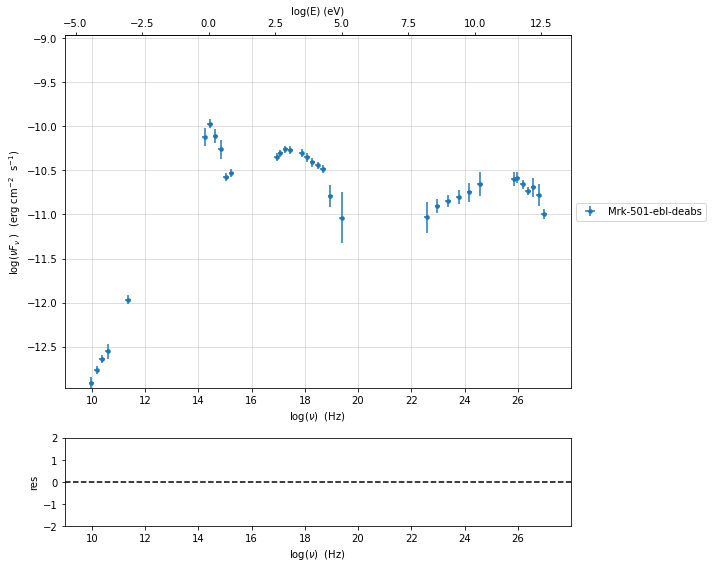

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



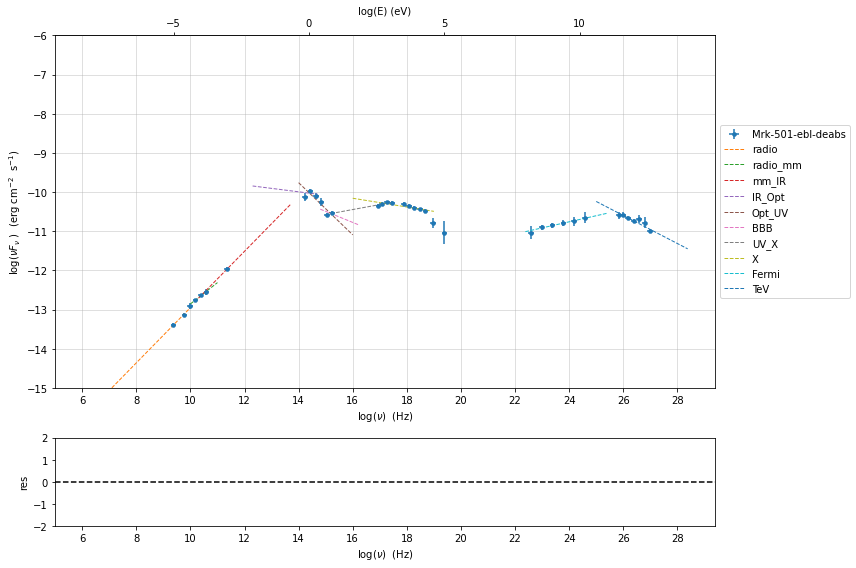

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### Sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411144e-02,-6.411144e-02,7.838965e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751721e-03,-1.751721e-03,1.127030e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437354e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884114e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006557e+01,-1.006557e+01,5.462528e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730764e-02,1.730764e-02,3.694887e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437354e-02)  nuFnu_p=-1.030068e+01 (err=+1.884114e-02) curv.=-6.411144e-02 (err=+7.838965e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.310993e-01,-1.310993e-01,3.244188e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-3.300446e-02,-3.300446e-02,2.072521e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.549603e+01,2.549603e+01,2.235473e-01,--,2.556357e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.057945e+01,-1.057945e+01,4.332978e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.549603e+01 (err=+2.235473e-01)  nuFnu_p=-1.057945e+01 (err=+4.332978e-02) curv.=-1.310993e-01 (err=+3.244188e-02)



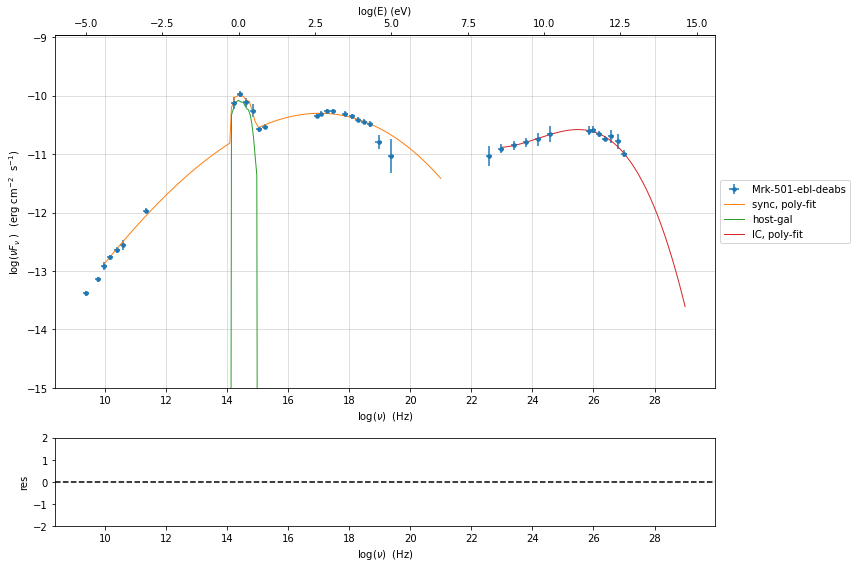

In [8]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


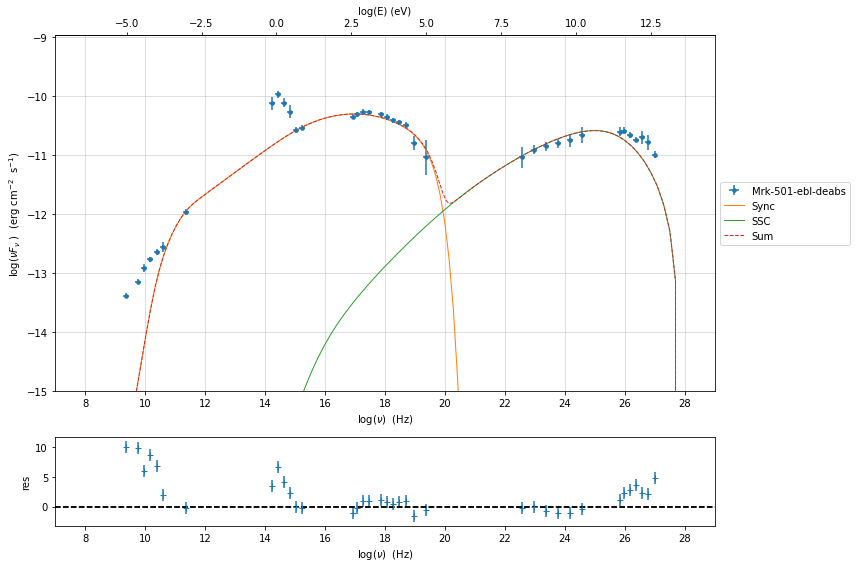

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting

### Model fitting with LSB

In [11]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [12]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model_lsb.show_model()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
jet model description
--------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.487509e+02
 gmax grid : 2.310708e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: o

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
model description
--------------------------------------------------------------------------------
name: host_galaxy  
type: template  

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (cm2 s),-1.006557e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.730764e-02,-2.000000e+00,2.000000e+00,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [13]:
fit_model_lsb.composite_expr='jet_leptonic + host_galaxy '

In [14]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [15]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=8.40104e+00
fit run: 1
- old chisq=8.40104e+00


0it [00:00, ?it/s]


- best chisq=8.31095e+00
fit run: 2
- old chisq=8.31095e+00


0it [00:00, ?it/s]


- best chisq=8.31095e+00
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,9.296480e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.076505e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.785727e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,5.741810e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.178384e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.281633e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.354274e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.250348e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.364376e+01,1.000000e-04,--,False,False



converged=True
calls=22
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=8.310950, chisq/red=0.395760 null hypothesis sig=0.993679

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,9.296480e+01,9.296480e+01,1.556202e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.076505e+06,2.076505e+06,1.226398e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.785727e+01,2.785727e+01,8.168846e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.741810e+03,5.741810e+03,9.834144e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.178384e+00,2.178384e+00,1.873598e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.281633e-01,2.281633e-01,4.564839e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.354274e+16,1.354274e+16,2.281064e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.250348e-02,1.250348e-02,7.877401e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.364376e+01,4.364376e+01,2.642363e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




In [33]:
best_fit_lsb.save_report('SSC-best-fit-lsb.txt')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.296480e+01,9.296480e+01,1.556202e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.076505e+06,2.076505e+06,1.226398e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.785727e+01,2.785727e+01,8.168846e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.741810e+03,5.741810e+03,9.834144e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.178384e+00,2.178384e+00,1.873598e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.281633e-01,2.281633e-01,4.564839e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.354274e+16,1.354274e+16,2.281064e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.250348e-02,1.250348e-02,7.877401e-03,--,5.050000e-02,0.000000e+00,--,False


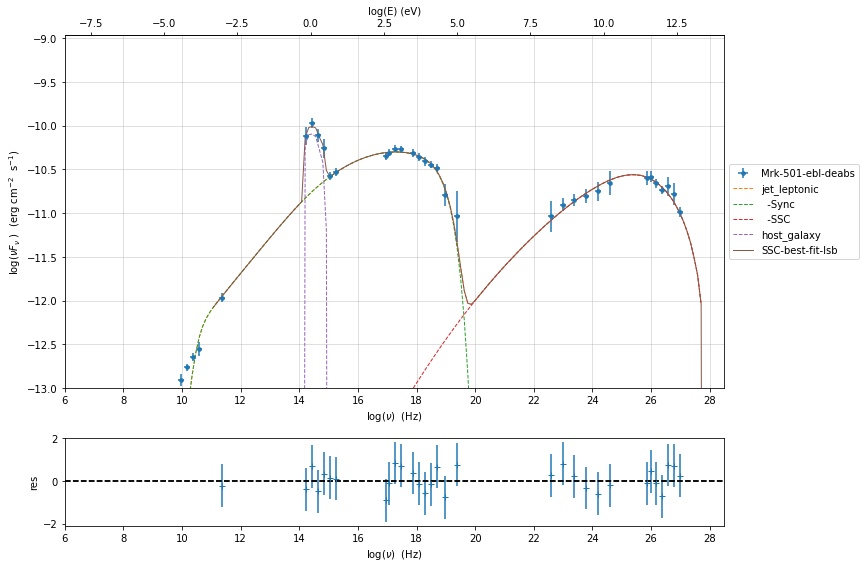

In [34]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

### Model fitting with Minuit

In [26]:
jet_minuit=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_minuit.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [27]:
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=my_shape.host_gal) 
fit_model_minuit.show_model_components()
fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,5E5]

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-minuit',repeat=3)


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=8.10845e+00
fit run: 1
- old chisq=8.10845e+00


0it [00:00, ?it/s]


- best chisq=8.10841e+00
fit run: 2
- old chisq=8.10841e+00


0it [00:00, ?it/s]


- best chisq=8.10836e+00
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,7.999238e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.206678e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.351730e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.370578e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.122821e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.093787e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.640643e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.087639e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.265225e+01,1.000000e-04,--,False,False



converged=True
calls=232
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.108                      │       Ncalls = 232 (232 total)       │
│ EDM = 2.77e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │   80.0    │    2.6    │            │            │   10    │  1000   │       │
│ 1 │ par_1 │   2.2e6   │   1.0e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   23.5    │    0.8    │            │            │    0    │         │       │
│ 3 │ par_3 │  3.37e3   │  0.13e3   │            │            │  1000   │ 500000  │       │
│ 4 │ par_4 │   2.123   │   0.004   │            │            │   -10   │   10    │       │
│ 5 │ par_5 │  0.2094   │  0.0035   │            │            │   -15   │   15    │       │
│ 6 │ par_6 │ 16.41e15  │  0.31e15  │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  0.0109   │  0.0012   │            │            │    0    │         │       │
│ 8 │ par_8 │   42.7    │    0.5    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.06   │   0.04    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=21
chisq=8.108363, chisq/red=0.386113 null hypothesis sig=0.994668

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,7.999238e+01,7.999238e+01,2.641099e+00,--,1.487509e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,2.206678e+06,2.206678e+06,9.946212e+05,--,2.310708e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,2.351730e+01,2.351730e+01,7.973007e-01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.370578e+03,3.370578e+03,1.303130e+02,--,1.045843e+04,1.000000e+03,5.000000e+05,False
jet_leptonic,s,2.122821e+00,2.122821e+00,4.406770e-03,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.093787e-01,2.093787e-01,3.530476e-03,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.640643e+16,1.640643e+16,3.105900e+14,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.087639e-02,1.087639e-02,1.229448e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.265225e+01,4.265225e+01,4.800473e-01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/v1.5.4/

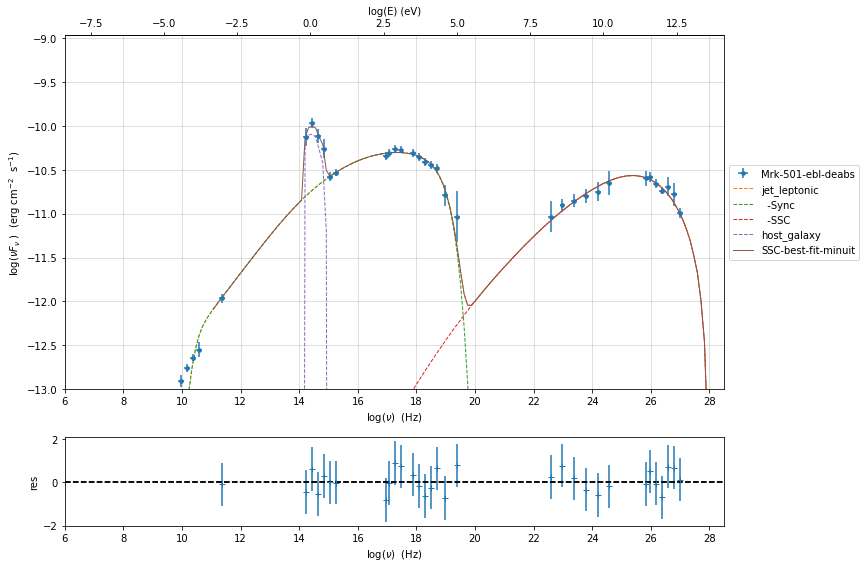

In [28]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [29]:
best_fit_minuit.save_report('SSC-best-fit-minuit.txt')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.296480e+01,9.296480e+01,1.556202e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.076505e+06,2.076505e+06,1.226398e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.785727e+01,2.785727e+01,8.168846e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.741810e+03,5.741810e+03,9.834144e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.178384e+00,2.178384e+00,1.873598e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.281633e-01,2.281633e-01,4.564839e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.354274e+16,1.354274e+16,2.281064e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.250348e-02,1.250348e-02,7.877401e-03,--,5.050000e-02,0.000000e+00,--,False


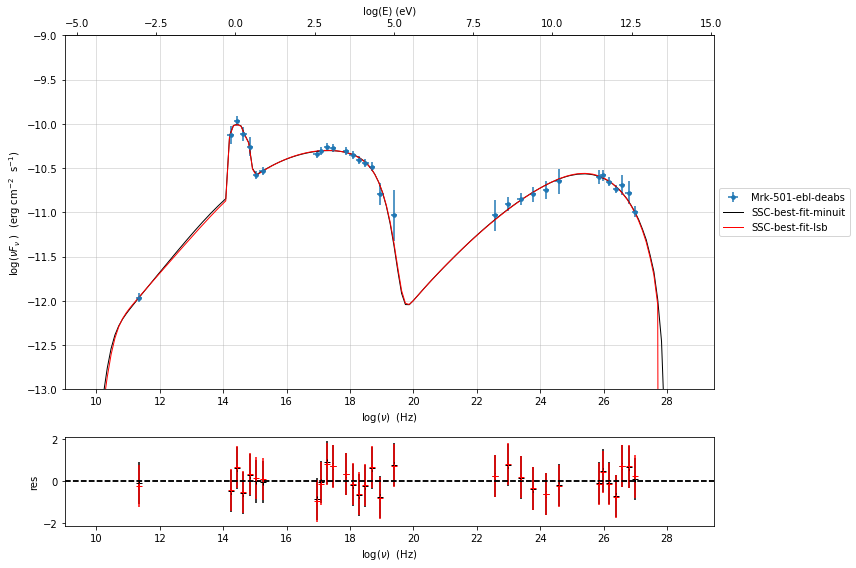

In [30]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11., 29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.rescale(y_min=-13,y_max=-9,x_min=9,x_max=29.5)

### Model fitting with a bkn pl


In [35]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


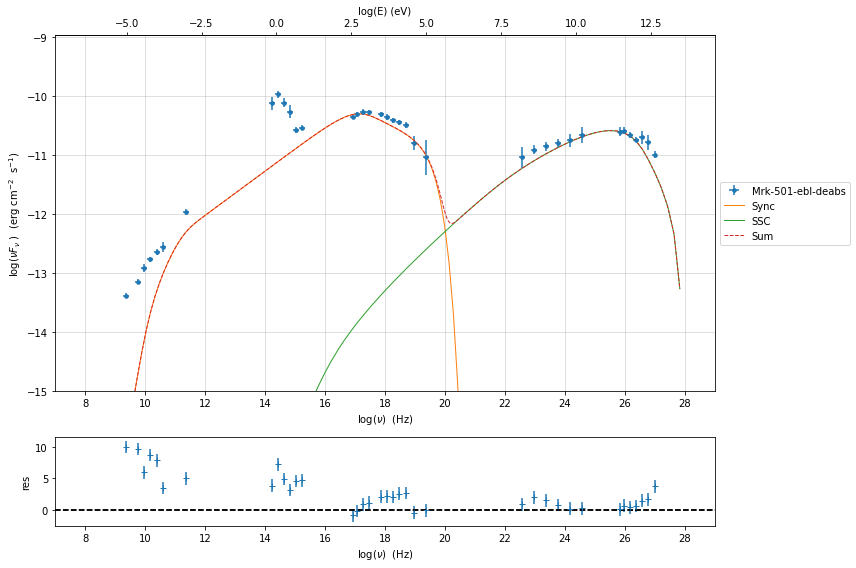

In [36]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

In [37]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_lsb_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_lsb_bkn.freeze(jet_lsb,'z_cosm')
fit_model_lsb_bkn.freeze(jet_lsb,'R_H')
fit_model_lsb_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_lsb_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_lsb_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=3)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=1.03910e+01
fit run: 1
- old chisq=1.03910e+01


0it [00:00, ?it/s]


- best chisq=1.03712e+01
fit run: 2
- old chisq=1.03712e+01


0it [00:00, ?it/s]


- best chisq=1.03712e+01
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.508123e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.731131e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.742838e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.481682e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.245314e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.955656e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.340182e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.410984e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.093266e+01,1.000000e-04,--,False,False



converged=True
calls=21
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=10.371200, chisq/red=0.493867 null hypothesis sig=0.973678

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.508123e+02,1.508123e+02,1.352894e+02,--,1.927085e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.731131e+06,1.731131e+06,7.971782e+05,--,2.993548e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,1.742838e+01,1.742838e+01,1.817798e+01,--,2.003808e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.481682e+04,5.481682e+04,3.559044e+04,--,2.012047e+05,1.000000e+00,1.000000e+09,False
jet_leptonic,p,2.245314e+00,2.245314e+00,1.406859e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,2.955656e+00,2.955656e+00,5.714302e-02,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,R,1.340182e+16,1.340182e+16,1.616766e+16,--,1.092459e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.410984e-02,1.410984e-02,8.428057e-03,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.093266e+01,4.093266e+01,1.815767e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




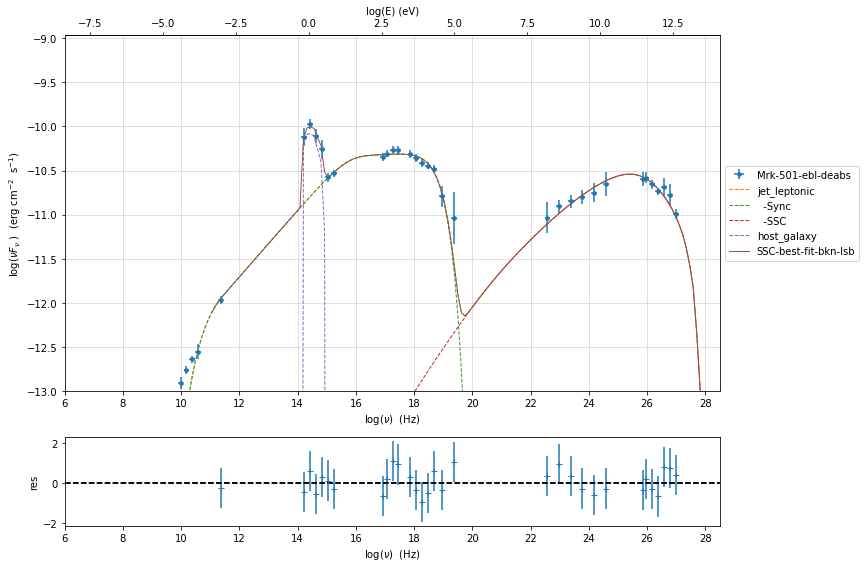

In [39]:
%matplotlib inline
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=fit_model_lsb_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [42]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)


fit_model_minuit_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-minuit-bkn',template=my_shape.host_gal) 
fit_model_minuit_bkn.show_model_components()
fit_model_minuit_bkn.freeze('jet_leptonic','z_cosm')
fit_model_minuit_bkn.freeze('jet_leptonic','R_H')
fit_model_minuit_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_minuit_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit_bkn.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit_bkn.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit_bkn.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit_bkn.jet_leptonic.parameters.gamma_break.fit_range=[1E3,1E6]
fit_model_minuit_bkn.jet_leptonic.parameters.p.fit_range=[1,3]
fit_model_minuit_bkn.jet_leptonic.parameters.p_1.fit_range=[2,5]


model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_minuit_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit-bkn  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=1.04693e+01
fit run: 1
- old chisq=1.04693e+01


0it [00:00, ?it/s]


- best chisq=1.04383e+01
fit run: 2
- old chisq=1.04383e+01


0it [00:00, ?it/s]


- best chisq=1.04383e+01
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit-bkn


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.347072e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.789881e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.890036e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.700211e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.244991e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.963614e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.399196e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.359199e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.080182e+01,1.000000e-04,--,False,False



converged=True
calls=177
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.44                      │       Ncalls = 177 (177 total)       │
│ EDM = 4.1e-05 (Goal: 0.0002)     │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │    135    │     7     │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  1.790e6  │  0.031e6  │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   18.9    │    2.5    │            │            │    0    │         │       │
│ 3 │ par_3 │   57e3    │    7e3    │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4 │   2.245   │   0.021   │            │            │    1    │    3    │       │
│ 5 │ par_5 │   2.96    │   0.04    │            │            │    2    │    5    │       │
│ 6 │ par_6 │  14.0e15  │  0.8e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  13.6e-3  │  0.9e-3   │            │            │    0    │         │       │
│ 8 │ par_8 │   40.8    │    1.0    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.05   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=21
chisq=10.438272, chisq/red=0.497061 null hypothesis sig=0.972641

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.347072e+02,1.347072e+02,7.387719e+00,--,1.927085e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,1.789881e+06,1.789881e+06,3.102305e+04,--,2.993548e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,1.890036e+01,1.890036e+01,2.508897e+00,--,2.003808e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.700211e+04,5.700211e+04,6.618752e+03,--,2.012047e+05,1.000000e+03,1.000000e+06,False
jet_leptonic,p,2.244991e+00,2.244991e+00,2.143237e-02,--,2.248787e+00,1.000000e+00,3.000000e+00,False
jet_leptonic,p_1,2.963614e+00,2.963614e+00,3.787257e-02,--,3.500000e+00,2.000000e+00,5.000000e+00,False
jet_leptonic,R,1.399196e+16,1.399196e+16,8.007647e+14,--,1.092459e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.359199e-02,1.359199e-02,9.193824e-04,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.080182e+01,4.080182e+01,9.887688e-01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




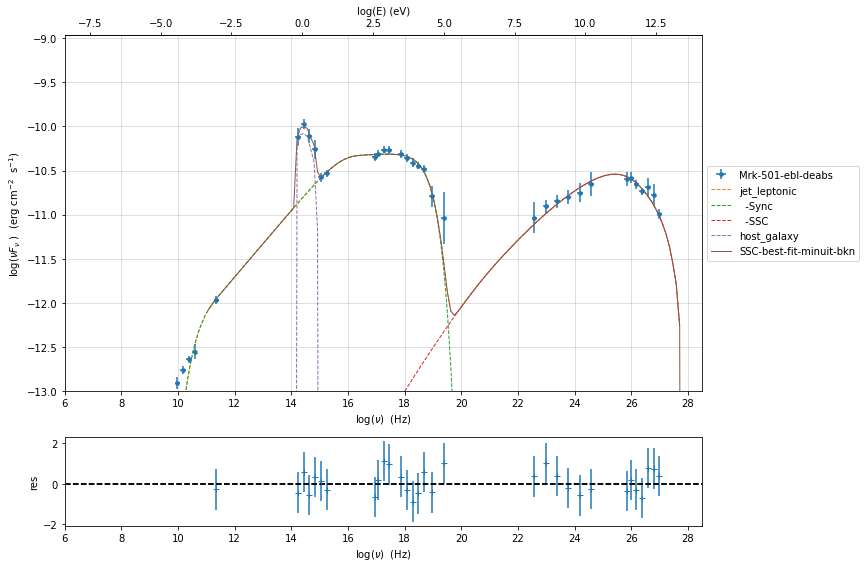

In [43]:
%matplotlib inline
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_minuit_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

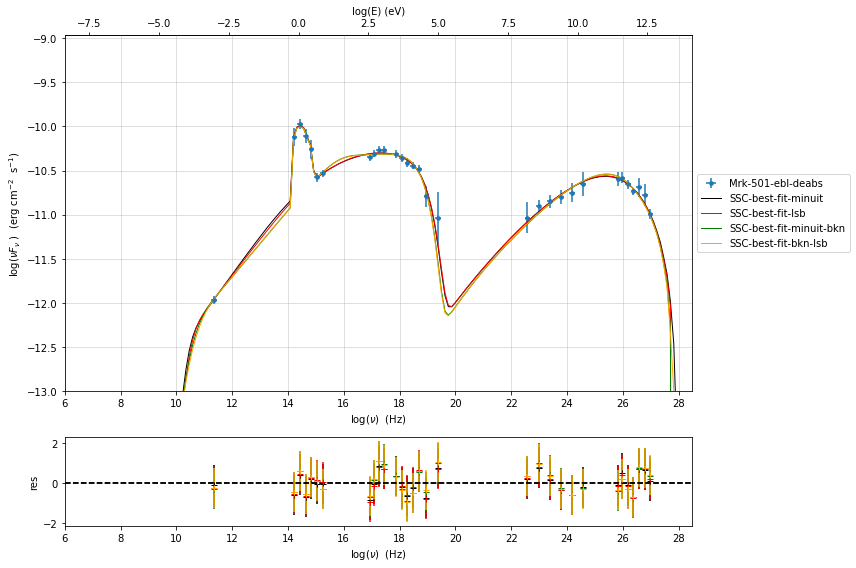

In [44]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11. ,29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.add_model_plot(fit_model_minuit_bkn,color='green')
p2.add_residual_plot(fit_model_minuit_bkn,sed_data,fit_range=[ 11., 29.],color='green')
p2.add_model_plot(fit_model_lsb_bkn,color='orange')
p2.add_residual_plot(fit_model_lsb_bkn,sed_data,fit_range=[ 11., 29.],color='orange')
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

## MCMC sampling

In [45]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used



In [46]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 441.46 seconds


In [47]:
print(mcmc.acceptance_fraction)

0.5528124999999999


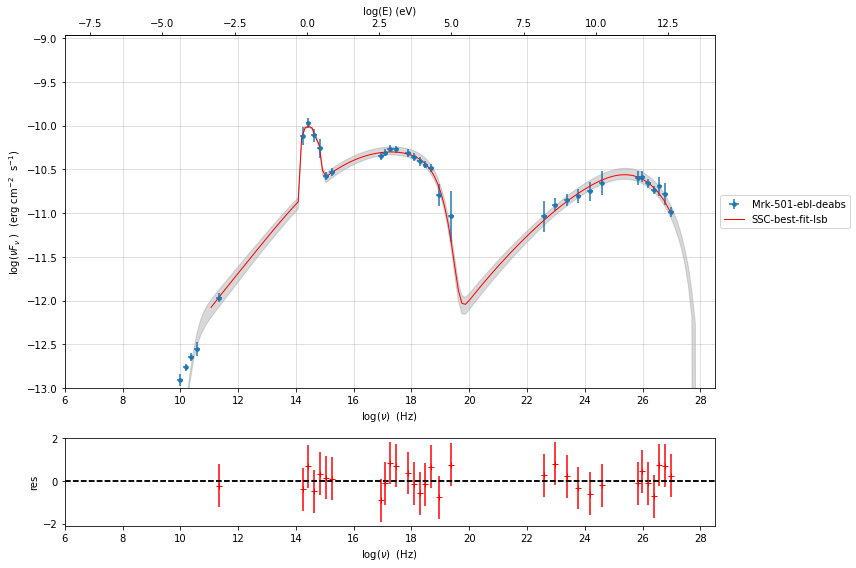

In [48]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[11., 27.],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

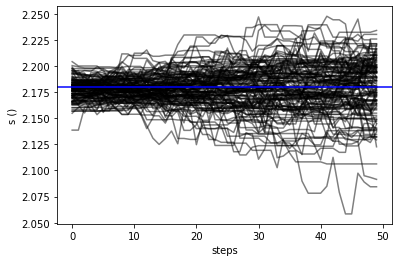

In [49]:
f=mcmc.plot_chain('s',log_plot=False)

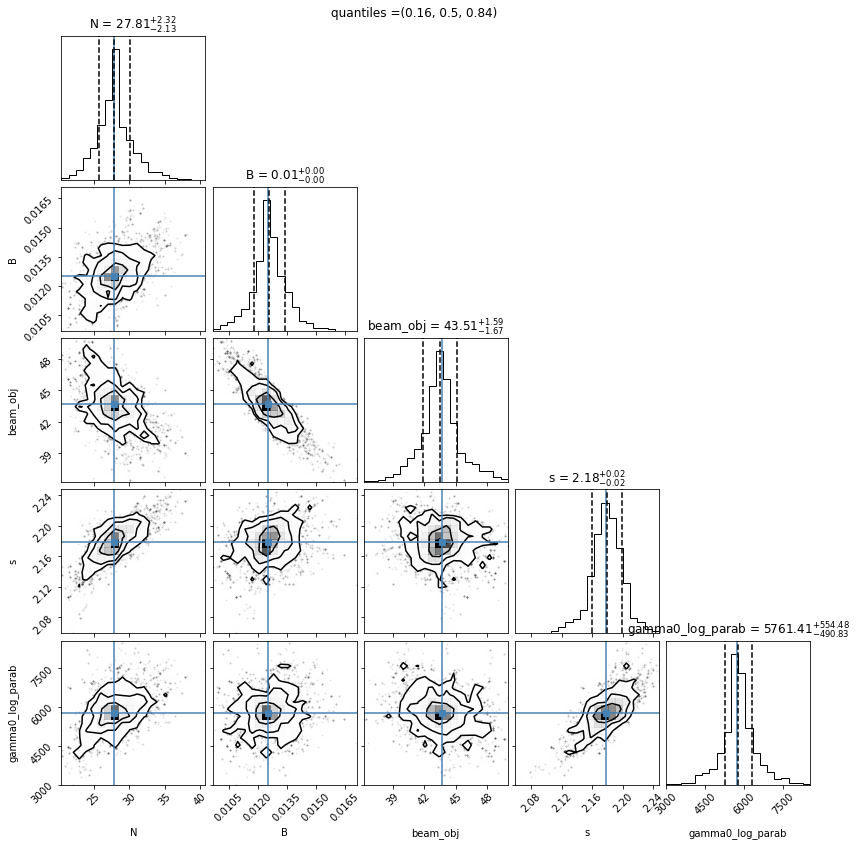

In [50]:
f=mcmc.corner_plot()

In [51]:
mcmc.get_par('N')

(array([27.13365648, 27.56888754, 27.44743786, ..., 31.04123012,
        20.41634151, 31.10457229]),
 0)

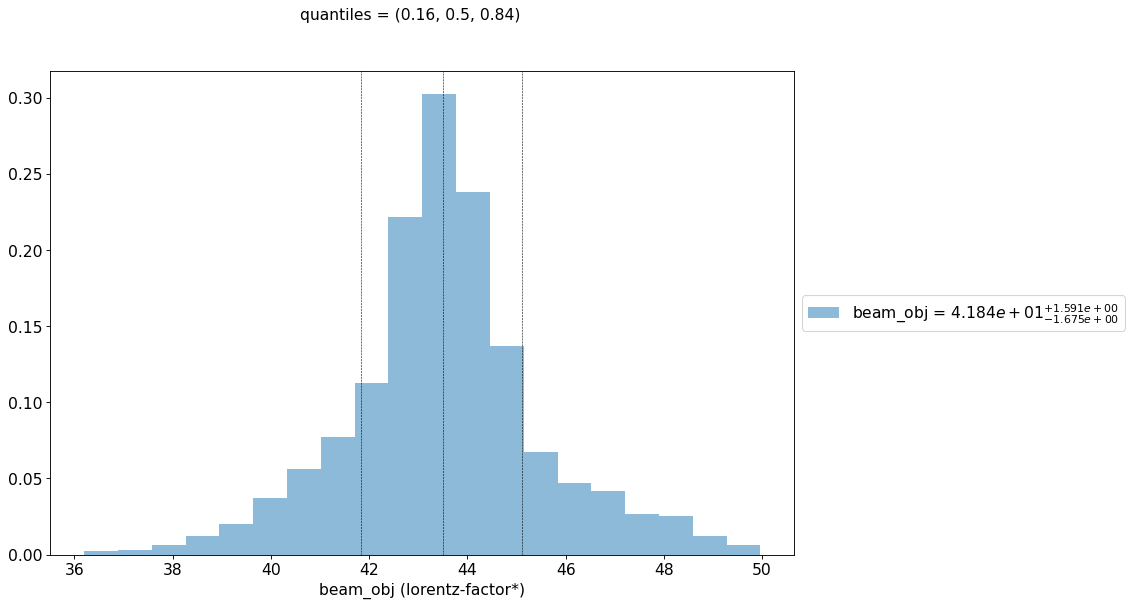

In [52]:
f=mcmc.plot_par('beam_obj')

The posterior of the beaming factor is clearly truncated, so we should rerun the fit changing the constrain on `beam_obj` parameter.

In [53]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [54]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 


In [55]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 100.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [56]:
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3,silent=True)

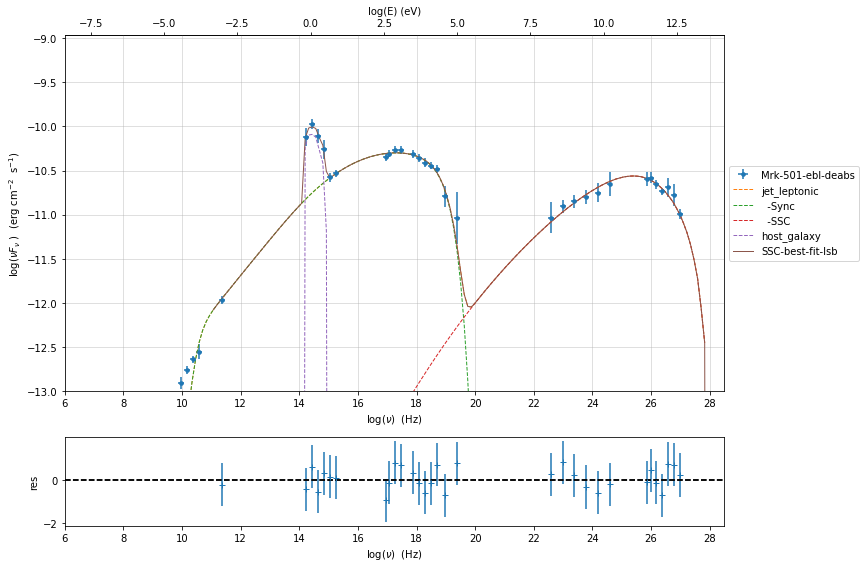

In [57]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [58]:
best_fit_lsb.save_report('SSC-best-fit-lsb.txt')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

In [59]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 452.72 seconds


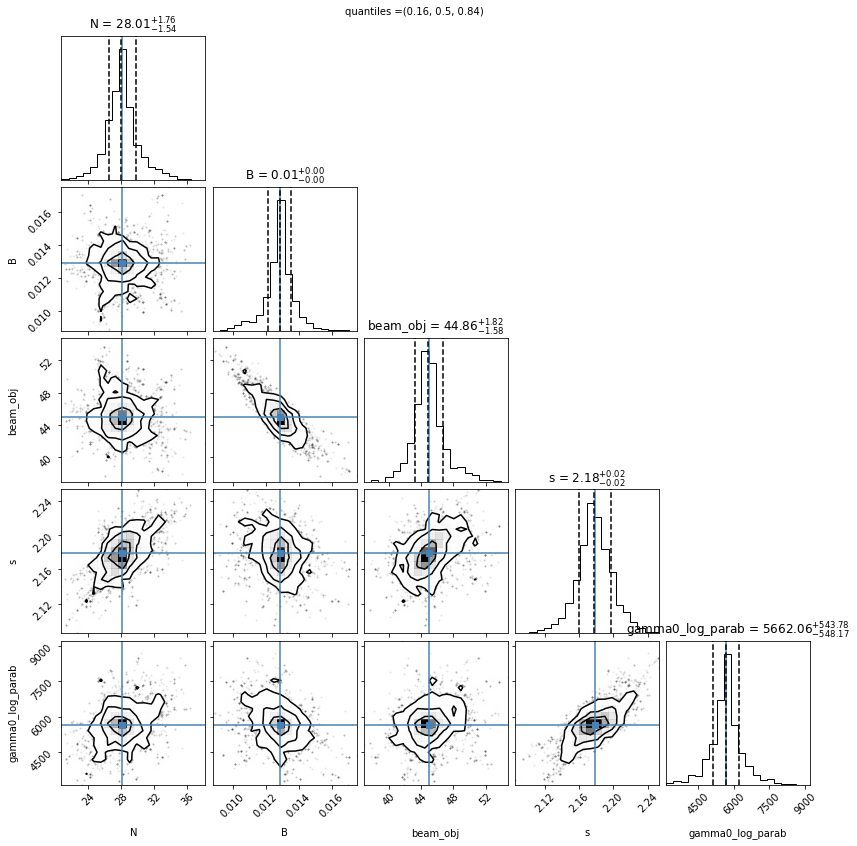

In [60]:
f=mcmc.corner_plot()

## Save and reuse MCMC

In [61]:
mcmc.save('mcmc_sampler.pkl')

In [62]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

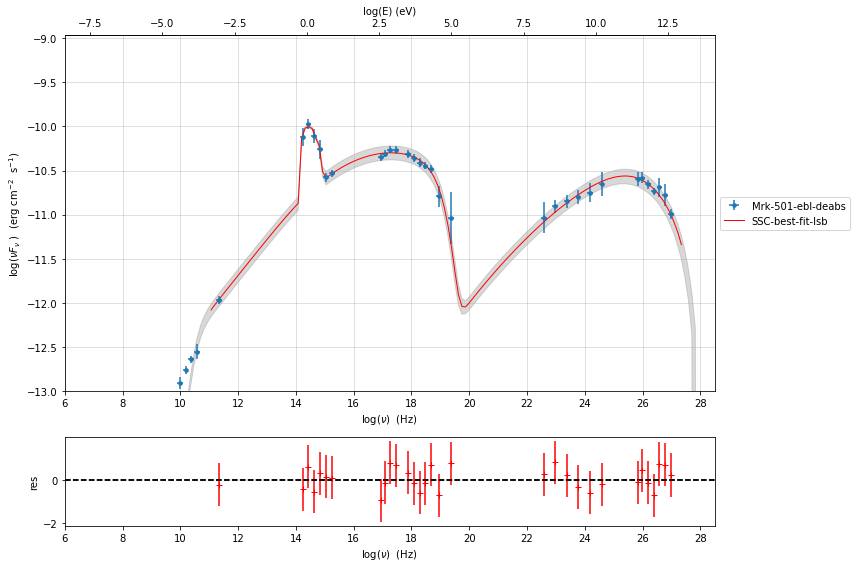

In [63]:
p=ms.plot_model(sed_data=sed_data,fit_range=[11., 27.4],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

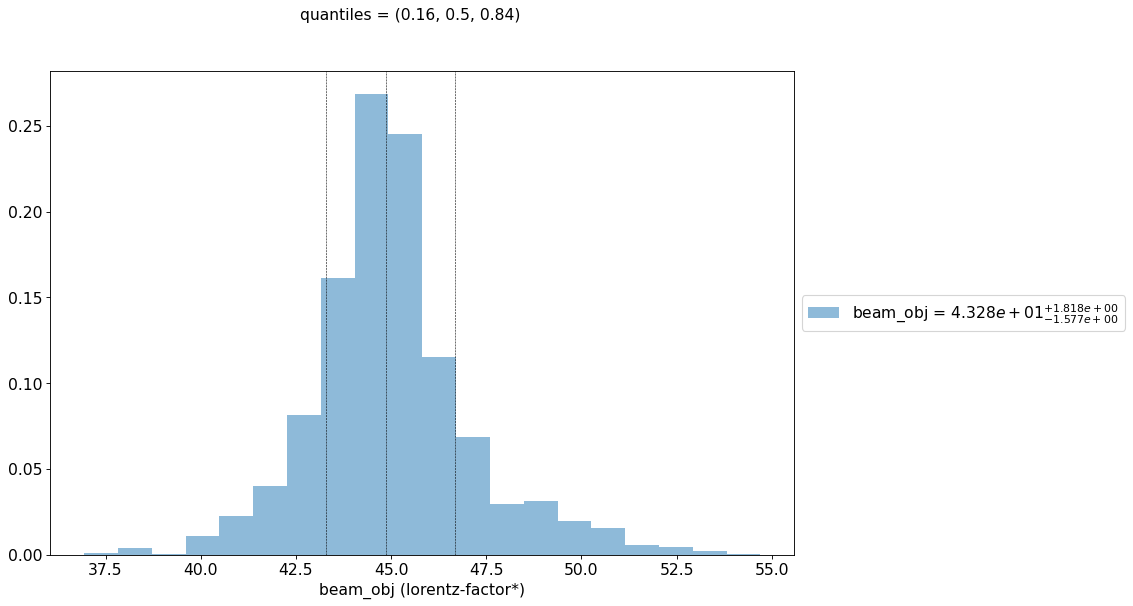

In [64]:
f=ms.plot_par('beam_obj',log_plot=False)


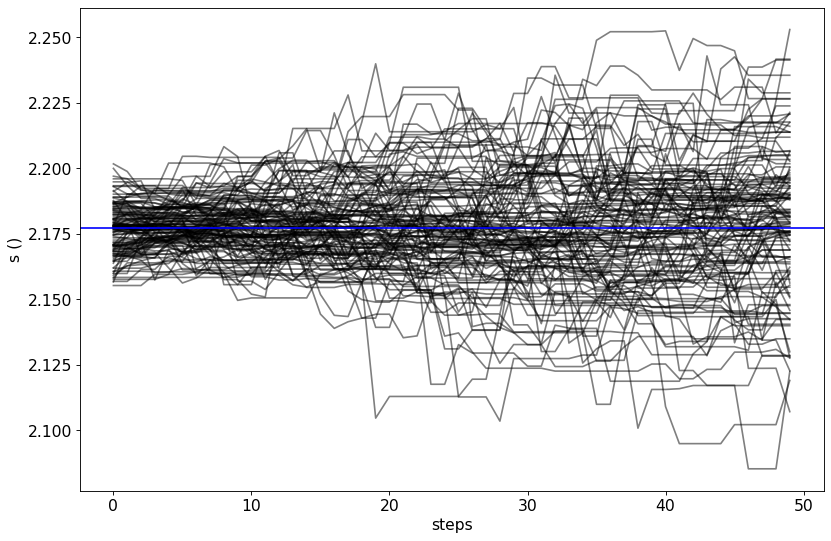

In [65]:
f=ms.plot_chain('s',log_plot=False)